<a href="https://colab.research.google.com/github/AvikantSrivastava/GANs/blob/master/DC_GAN_on_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
 
import numpy as np
from skimage.transform import resize
# import skimage.transform as st
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
 
 
import matplotlib.pyplot as plt
 
import os
 
import time

In [3]:
def get_generator():
        
    model = tf.keras.Sequential()
 
    # input layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(32,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(f'[1] output shape is : {model.output_shape}')
 
    model.add(layers.Reshape((4, 4, 1024)))
    print(f'[2] output shape is : {model.output_shape}')
 
    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(f'[3] output shape is : {model.output_shape}')
 
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(f'[4] output shape is : {model.output_shape}')
 
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(f'[5] output shape is : {model.output_shape}')
 
    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(f'[3] output shape is : {model.output_shape}')
 
 
    return model

In [4]:
# generator_model = get_generator()
# /content/drive/My Drive/DC_GAN/generator_model.h5

generator_on_drive = '/content/drive/My Drive/DC_GAN/generator_model[2020-08-03 06:36:00.696223].h5'

generator_model = tf.keras.models.load_model(generator_on_drive)

In [5]:
generator_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16384)             524288    
_________________________________________________________________
batch_normalization_30 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 512)         4718592   
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 8, 8, 512)       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


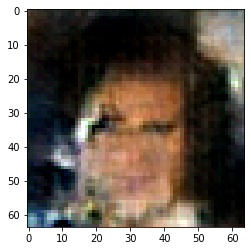

In [14]:
noise = tf.random.normal([1, 32])
generated_image = generator_model(noise, training=False)
 
plt.imshow(generated_image[0, :, :, : ], )

In [15]:
def get_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(f'[1] output shape is : {model.output_shape}')


    # model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.DepthwiseConv2D((5, 5), strides=(2, 2), padding='same', depth_multiplier=2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(f'[2] output shape is : {model.output_shape}')

    # model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.DepthwiseConv2D((5, 5), strides=(2, 2), padding='same', depth_multiplier=2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(f'[3] output shape is : {model.output_shape}')


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [16]:
# discriminator_model = get_discriminator()
# /content/drive/My Drive/DC_GAN/discriminator_model.h5

discriminator_on_drive = '/content/drive/My Drive/DC_GAN/discriminator_model2020-08-03 06:36:00.696223.h5'

discriminator_model = tf.keras.models.load_model(discriminator_on_drive)


discriminator_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
depthwise_conv2d_12 (Depthwi (None, 16, 16, 128)       3328      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
depthwise_conv2d_13 (Depthwi (None, 8, 8, 256)       

In [17]:
# check if the models work together
decision = discriminator_model(generated_image)
print (decision)

tf.Tensor([[-0.24996427]], shape=(1, 1), dtype=float32)


In [18]:
# loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [19]:
# discriminator loss
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
#optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:

#save chackpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

In [23]:
!wget  -x --load-cookies /content/drive/My\ Drive/DC_GAN/kaggle-cookies.txt "https://www.kaggle.com/jessicali9530/celeba-dataset/download" -O data.zip



--2020-08-03 11:51:18--  https://www.kaggle.com/jessicali9530/celeba-dataset/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-data-sets/29561%2F37705%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1596714678&Signature=BVxBEQFBnvMwFfN3sem7s5R%2BaeRF4pXBVJrZwLpGRKQqu0C0vkwM%2Bt8FZ8RW17e3qL%2F6T66RJQAyhFU6%2Bunvcbrim1iP%2BmaJimJW5IIsyk99lhBLiMrpYOl%2BjPgJ64%2B942dedLqibv4TaaMY2AdD9U8Jkr23nFpsWafnkY7fRLpTs7TUggX1DbGCOrytSufldbjuKjyivUCXTB2oNFLQEzdglpauRxm%2FrAuxZb9%2BYvWhJuFDSKKgyBPdG4OYxvlbiCoEcBPdke2nH%2FFhgGuo6Uou%2BfJzL4QewQ4xJVK0L4Gpl4wCHoG74FD2dy6X1odVe2B1c6NbWbNOCp%2Fv3N%2FbpQ%3D%3D [following]
--2020-08-03 11:51:18--  https://storage.googleapis.com/kaggle-data-sets/29561%2F37705%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-

In [24]:
!unzip data.zip


Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [25]:
!ls -l img_align_celeba

total 5688
drwxr-xr-x 2 root root 5824512 Aug  3 11:53 img_align_celeba


100%|██████████| 10000/10000 [00:15<00:00, 625.05it/s]


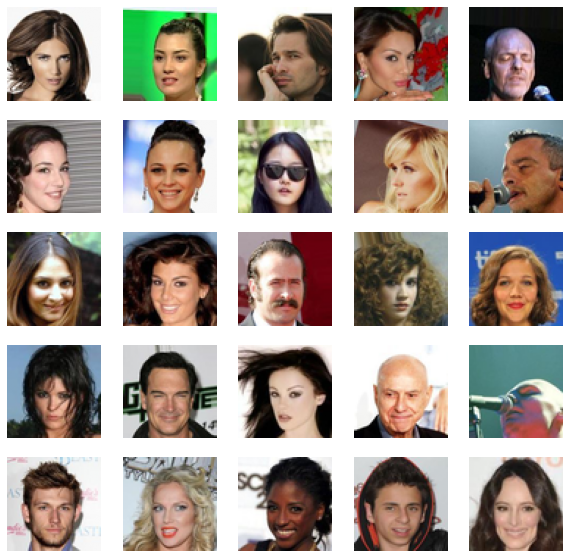

In [26]:
PIC_DIR = './img_align_celeba/img_align_celeba/'
IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 64
HEIGHT = 64

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))
#Normalize the images
images = np.array(images) / 255
images.shape
#print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [27]:
images.shape

(10000, 64, 64, 3)

In [29]:
@tf.function
def train_step(images):

      # making the images numpy array like to feed into discriminator model

      
    

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))



In [30]:
import datetime


def save_model_to_drive():
  timestamp = datetime.datetime.now()

  generator_model.save(f'/content/drive/My Drive/DC_GAN/generator_model[{timestamp}].h5')

  discriminator_model.save(f'/content/drive/My Drive/DC_GAN/discriminator_model[{timestamp}].h5')


In [31]:
save_model_to_drive()

In [36]:
from IPython import display



def train(dataset, epochs = 250):
  for epoch in range(epochs):
    start = time.time()

    for i in range(0, dataset.shape[0], BATCH_SIZE ):
      image_batch = dataset[ i: i + BATCH_SIZE , : , : , : ]
      # print(image_batch.shape)
      
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                             epoch + 1,
                             seed)
    
    # save model to drive after every 100 epochs
    if (epoch + 1) % 50 == 0:
        save_model_to_drive()

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model ,
                           epochs,
                           seed)

In [33]:
!mkdir gen_images

In [34]:
def generate_and_save_images(model, epoch, test_input):  
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  predictions = predictions * 127.5
  predictions = tf.cast(predictions, tf.int32, name=None)

  fig = plt.figure(figsize=(25,25))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow( predictions[i, :, :, : ] ,  )
      plt.axis('off')

  plt.savefig('gen_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [35]:
# training
EPOCHS = 500
noise_dim = 32
BATCH_SIZE = 128
num_examples_to_generate = 4

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


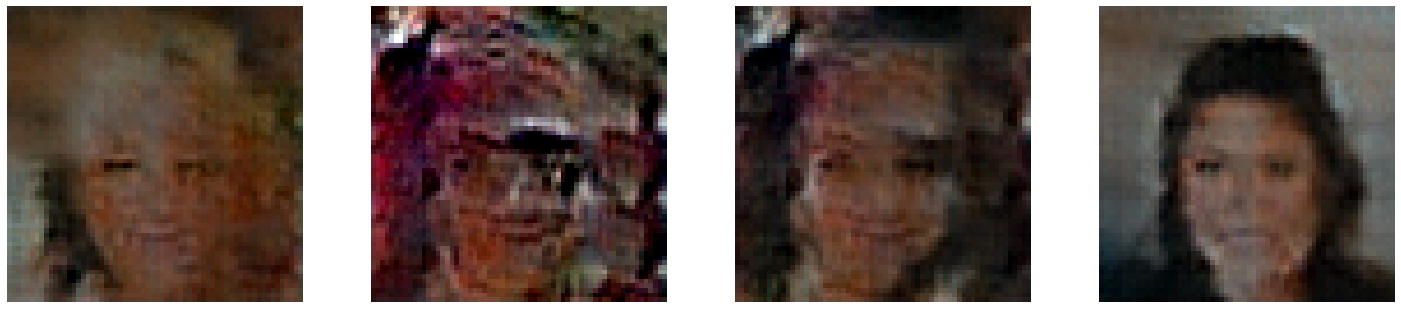

Time for epoch 66 is 22.171068906784058 sec


In [ ]:
train(images, )


In [ ]:
# saving the models

generator_model.save('generator_model.h5')

discriminator_model.save('discriminator_model.h5')

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('generator_model.h5')
  files.download('discriminator_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
import glob
import imageio

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('gen_images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [58]:

!cp dcgan.gif /content/drive/My\ Drive/DC_GAN/saved_gifs/dcgan1.gif

In [55]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>